https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb#scrollTo=hoT-VFSdOANz

In [1]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: not using Google CoLab
Using device: cpu


/home/agtech-research/문서/tomato2023/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
BATCH_SIZE = 32

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [4]:
df = pd.read_csv("merged.csv", usecols=["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1"])
df_train = df.iloc[:8000]
df_test = df[8000:10000]

x_cols = ["EXTN_TPRT", "INNER_HMDT_1"]
y_cols = ["INNER_TPRT_1"]
cols = x_cols + y_cols

spots_train = df_train[cols] #.to_numpy().reshape(-1, len(cols))
spots_test = df_test[cols] #.to_numpy().reshape(-1, len(cols))

spots_train[:5], spots_test[:5]

(   EXTN_TPRT  INNER_HMDT_1  INNER_TPRT_1
 0      -1.35         87.05         15.45
 1      -1.30         87.45         15.30
 2      -1.50         88.40         15.25
 3      -1.55         87.95         15.30
 4      -1.40         87.95         15.35,
       EXTN_TPRT  INNER_HMDT_1  INNER_TPRT_1
 8000       2.67         85.37         13.87
 8001       2.57         85.17         13.80
 8002       2.50         86.20         13.53
 8003       2.37         85.20         13.83
 8004       2.47         86.43         13.50)

In [25]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(df, seq_size=SEQUENCE_SIZE):
    num_len = len(df) - seq_size
    x = np.zeros((num_len, seq_size, len(x_cols)))
    y = np.zeros((num_len, len(y_cols)))
    for i in range(len(df) - seq_size):
        x[i] = df[x_cols].iloc[i:(i + seq_size)].to_numpy()
        y[i] = df[y_cols].iloc[i + seq_size].to_numpy()
    return (
        torch.tensor(x, dtype=torch.float32), 
        torch.tensor(y, dtype=torch.float32) 
    )

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

x_train.shape, y_train.shape

(torch.Size([7990, 10, 2]), torch.Size([7990, 1]))

In [22]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_size=1, d_model=32, nhead=4, num_layers=1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [29]:
# Train the model
model = TransformerModel(
    input_dim=len(x_cols), 
    output_size=len(y_cols)
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

In [30]:
import matplotlib.pyplot as plt

epochs = 10
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")
    



Epoch 1/10, Validation Loss: 13.9914
Epoch 2/10, Validation Loss: 10.1155
Epoch 3/10, Validation Loss: 10.3552
Epoch 4/10, Validation Loss: 9.8466
Epoch 5/10, Validation Loss: 7.9222
Epoch 6/10, Validation Loss: 8.0142
Epoch 7/10, Validation Loss: 11.6586
Epoch 8/10, Validation Loss: 11.0656
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch 9/10, Validation Loss: 11.6589
Epoch 10/10, Validation Loss: 10.6868


In [31]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean(
    (np.array(predictions).reshape(-1, 1) - y_test.numpy().reshape(-1, 1)))**2
)
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 1.2833


In [32]:

x_test.shape, y_test.shape, np.array(predictions).shape

(torch.Size([1990, 10, 2]), torch.Size([1990, 1]), (1990,))

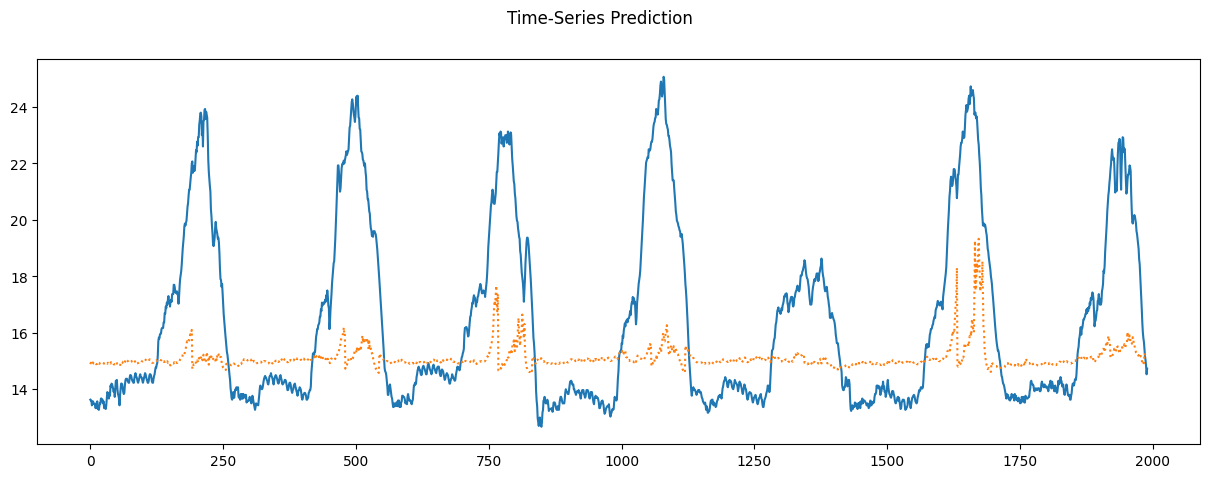

In [33]:
plt.figure(figsize=(15, 5)) 
plt.plot(y_test)
plt.plot(predictions, linestyle='dotted')
plt.suptitle('Time-Series Prediction')
plt.show()